In [15]:
%matplotlib widget
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import gensim.downloader as api
import numpy as np
import re
from tqdm import tqdm

# Load the Data

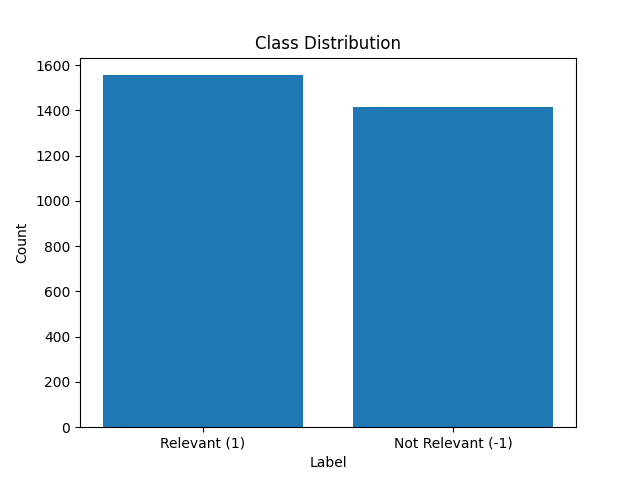

In [24]:
# Read the first Excel file
path = '../Datasets/sentiment_dataset/labeled/Human_Labeled/combined_dataset_apple_dove_delta_sprint.xlsx'
df = pd.read_excel(path)

# rename columns to [Keyword, Label, Text]
df.columns = ['Keyword', 'Label', 'Text']

# Make all Label = 0 to Label = -1 if not removing the @mentions
df.loc[df['Label'] == 0, 'Label'] = -1

# name columns to [Keyword, Label, Text]
df.columns = ['Keyword', 'Label', 'Text']

# Visualize the class distributions
class_counts = df['Label'].value_counts()
class_labels = ['Relevant (1)', 'Not Relevant (-1)']
# class_labels = ['Not Relevant', 'Relevant']
plt.figure()
plt.bar(class_labels, class_counts)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()


# Train SVC

In [3]:
# Load pre-trained word embeddings (word2vec)
word_vectors = api.load("word2vec-google-news-300")

In [25]:
# Feature extraction and SVC
def extract_features(text):
    if isinstance(text, str):
        tokens = text.lower().split()  # Tokenize and convert to lowercase
        word_embeddings = [word_vectors[token] for token in tokens if token in word_vectors]  # Get word embeddings
        return sum(word_embeddings) if word_embeddings else None  # Sum of word embeddings
    else:
        return None  # Return None for non-string inputs

df['Features'] = df['Text'].apply(extract_features)

# Remove rows with missing features
df = df.dropna()
df.loc[df['Label'] == 0, 'Label'] = -1

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['Features'].tolist(), df['Label'], random_state=42)

# Train a Support Vector Classifier (SVC)
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluation
print("Training size:", len(X_train))
print("Testing size:", len(X_test))

print(classification_report(y_test, y_pred))

# print confusion matrix 
print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred))
tp, fp, fn, tn = confusion_matrix(y_test, y_pred).ravel()
print("tp, fp, fn, tn: ", tp, fp, fn, tn)


Training size: 2225
Testing size: 742
              precision    recall  f1-score   support

          -1       0.87      0.82      0.85       370
           1       0.83      0.88      0.86       372

    accuracy                           0.85       742
   macro avg       0.85      0.85      0.85       742
weighted avg       0.85      0.85      0.85       742

Confusion Matrix: 
[[304  66]
 [ 44 328]]
tp, fp, fn, tn:  304 66 44 328


In [9]:
# for index, row in tqdm(df.iterrows()):
#     features = np.asarray(row["Features"]).reshape(1,-1)
#     SVC_pred = clf.predict(features)
#     df.at[index, 'SVC_pred'] = SVC_pred

2967it [00:01, 2696.28it/s]


In [26]:
# add the predictions to the dataframe
df['SVC_pred'] = clf.predict(df['Features'].tolist())
# remove rows containing training data from the original dataframe
df_test = df[~df['Features'].isin(X_train)]
# add a column calculating the difference between the true label and the SVC label
df_test['SVC_diff'] = df_test['Label'] - df_test['SVC_pred']
# rearrange the columns to keyword, label, SVC_pred, SVC_diff, text, features
df_test = df_test[['Keyword', 'Label', 'SVC_pred', 'SVC_diff', 'Text', 'Features']]
# rename columns to Keyword, True_label, SVC_label, SVC_diff, Text, Features
df_test.columns = ['Keyword', 'True_label', 'SVC_label', 'SVC_diff', 'Text', 'SVC_Features']
# sort by the diff then by keyword
df_test = df_test.sort_values(by=['SVC_diff', 'Keyword'])
# reset the index
df_test = df_test.reset_index(drop=True)
df_test

C:\Users\Nicor\AppData\Local\Temp\ipykernel_6316\1372694399.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['SVC_diff'] = df_test['Label'] - df_test['SVC_pred']


,Keyword,True_label,SVC_label,SVC_diff,Text,SVC_Features
0,apple,-1,1,-2,@zoopedup Apple Mail. Integrates seemlessly wi...,"[0.21679688, -0.40039062, -0.08532715, 0.90209..."
1,apple,-1,1,-2,"@TheFilmo Haha nopers, I'm a Snapple Fact frea...","[0.07601929, 0.36657715, 0.10336304, 1.1331787..."
2,apple,-1,1,-2,@omshivaprakash weatherunderground.com nali da...,"[0.20178223, 0.1574707, -0.48657227, 0.7407226..."
3,apple,-1,1,-2,I really wanted a slice of our apple pie. Made...,"[0.2236023, 0.30737305, 0.52941895, 1.5828247,..."
4,apple,-1,1,-2,OD'd on apple juice... that's not code for any...,"[0.7776489, -0.5467701, 1.6209412, 2.526123, -..."
...,...,...,...,...,...,...
737,delta,1,-1,2,@leesemp and I trying to make it home from a w...,"[0.39453125, 0.939414, 0.375, 0.66656494, -0.1..."
738,sprint,1,-1,2,@CashVerde but I have the latest curve from sp...,"[0.018554688, 0.5244837, 0.29907227, 1.3693848..."
739,sprint,1,-1,2,@SoCalMario sounds pretty sweet but it's only...,"[0.43530273, -0.17382812, -0.14086914, 1.13433..."
740,sprint,1,-1,2,Im bout to get that Sprint Palm Pre this morni...,"[-0.088134766, 0.07220459, -0.5410156, 0.76318..."


In [27]:
# save xlsx file
df_test.to_excel('../Datasets/sentiment_dataset/labeled/SVC/SVC_labeled_combined_4entities_test.xlsx', index=False)

# Improving P1 
### (run these next blocks independantly from the ones above)

In [21]:
# load the dataset
import pandas as pd
import re
path = '../Datasets/sentiment_dataset/labeled/SVC/SVC_labeled_combined_4entities_test.xlsx'
df = pd.read_excel(path)
    
def classify_update_apple(row):
    text = row['Text'].lower()

    # if text contains 'apple.com', classify as 1
    if re.search(r'\bapple.com\b|\bapple stores?\b', text):
        return 1
    
    # if the text contains words like ‘pineapple’, ‘applebees’, or ‘apple pie’, classify as -1.
    elif re.search(r'\bpineapples?\b|\bapplebees?\b|\bapple pies?\b|\bapple juices?\b', text):
        return -1
    else:
        return row['SVC_label']

def classify_update_sprint(row):
    text = row['Text'].lower()
    
    # if text contains 'palm pre', classify as 1
    if re.search(r'\bpalm pre\b', text):
        return 1
    
    # if text contains any variation of 'sprint' like 'sprinting', 'sprinted', 'sprints', classify as -1
    elif re.search(r'\bsprint(ing|ed|s)\b', text):
        return -1
    else:
        return row['SVC_label']


# Apply the updated classification to the dataframe
for index, row in df.iterrows():
    if row['Keyword'] == 'apple':    
        df.at[index, 'SVC_label'] = classify_update_apple(row)
    elif row['Keyword'] == 'sprint':
        df.at[index, 'SVC_label'] = classify_update_sprint(row)



# recalculate the SVC_diff and update the df
df['SVC_diff'] = df['True_label'] - df['SVC_label']
df = df.sort_values(by=['SVC_diff', 'Keyword'])
df = df.reset_index(drop=True)


# save xlsx file
df.to_excel('../Datasets/sentiment_dataset/labeled/SVC/SVC_labeled_combined_4entities_test_postProcessed.xlsx', index=False)

# New Results

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
# calculate classification stats and confusion matrix
print(classification_report(df['True_label'], df['SVC_label']))

print("Confusion Matrix: ")
print(confusion_matrix(df['True_label'], df['SVC_label']))
tp, fp, fn, tn = confusion_matrix(df['True_label'], df['SVC_label']).ravel()
print("tp, fp, fn, tn: ", tp, fp, fn, tn)

              precision    recall  f1-score   support

          -1       0.90      0.85      0.88       370
           1       0.86      0.91      0.88       372

    accuracy                           0.88       742
   macro avg       0.88      0.88      0.88       742
weighted avg       0.88      0.88      0.88       742

Confusion Matrix: 
[[314  56]
 [ 33 339]]
tp, fp, fn, tn:  314 56 33 339


# Old Results 
### (slightly different from above since some of the true labels were wrong)

In [23]:
# open the file
path = '../Datasets/sentiment_dataset/labeled/SVC/SVC_labeled_combined_4entities_test.xlsx'
df_old = pd.read_excel(path)
# calculate classification stats and confusion matrix
print(classification_report(df_old['True_label'], df_old['SVC_label']))
print("Confusion Matrix: ")
print(confusion_matrix(df_old['True_label'], df_old['SVC_label']))
tp, fp, fn, tn = confusion_matrix(df_old['True_label'], df_old['SVC_label']).ravel()
print("tp, fp, fn, tn: ", tp, fp, fn, tn)

              precision    recall  f1-score   support

          -1       0.87      0.82      0.85       370
           1       0.83      0.88      0.86       372

    accuracy                           0.85       742
   macro avg       0.85      0.85      0.85       742
weighted avg       0.85      0.85      0.85       742

Confusion Matrix: 
[[304  66]
 [ 44 328]]
tp, fp, fn, tn:  304 66 44 328
